
####  Created by Nicolas Donati, Pascal Vanier, Vicky Kalogeiton

In this tutorial, we will see some classic architectures of convolutional networks and how to use pre-trained networks to speed-up training on new tasks.

# ImageNet

The [ImageNet](http://www.image-net.org/) dataset is one of the main datasets used in image recognition. It contains more than 14 million images annotated according to the hierarchical structure of the [WordNet](https://wordnet.princeton.edu/) dataset.
Images are organized into classes and subclasses having semantic relationships, for example 'car' and 'plane' are 'vehicles', 'cat' and 'bird' are 'animals', 'plane' and 'bird' are 'flying objects', etc ...

ImageNet was accompanied by the challenge: 'Large Scale Visual Recognition Challenge' (ILSVRC), each edition offers different challenges (classification, detection, segmentation, ...) based on a subset of the dataset.

The advantage of having large datasets for learning is to be able to train networks on fairly general tasks, and after reuse the  learned weights for other applications. This operation is called transfer learning. A deep neural network (DNN) learns more and more abstract (hence high-level) features as one progresses through the layers.

Thus, a neural network (NN) pre-trained on a large dataset has low-level characteristics (learned in the first layers) potentially transferable to many tasks. These include texture, color, etc.  An immediate advantage is saving time as one does not have to re-train the NN for every new task from scratch. Another advantage is the fact that the models obtained are more robust. Indeed, a network pre-trained on a complete, large-scale dataset needs on the one hand fewer examples (since it has already seen a lot of them during the first training), and has less risk of over-learning the low level characteristics.

# AlexNet

In 2012, the [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) architecture won the ImageNet competition. The name comes from the first author Alex Krizhevsky. It is a CNN that classifies images into 1000 categories by producing a probability distribution over 1000 classes for each image. The metric used is the percentage of error among the *k* most probable classes (*top-k* error), i.e., we look to see if the true/correct prediction is among the *k* most probable classes predicted by the algorithm.
AlexNet got a top-5 error of 15.3% versus 26.2% for the second best result. This remarkable success led to the adoption of DNNs for the last decade.

Recall that a convolution takes as input a tensor of rank 3 whose first two axes are indexed according to the coordinates of the pixels ($W$, $H$ for width and height) and the last axis stores the channels (for RGB images this is 3). The convolutional kernel is a rank $4$ tensor whose first two axes are indexed according to the coordinates of the pixels supporting the kernel and the last two axes store a matrix of size $d_{in} \times d_{out}$ , where $d_{in}$ is the dimension of the features before convolution, and $d_{out}$ the dimension after the convolution, which will be applied to the input. 

The AlexNet architecture is illustrated in the following diagram:

![](https://drive.google.com/uc?export=view&id=1qXGfYOJRU0pgCcGydat0u2Y9csso9nIQ)

Images are represented by volumes whose height and width are the dimensions of the image and the depth is the number of channels. The size of the convolutional kernel is indicated by the small squares. For instance, we see that the input image is an RGB image of size 224 by 224 and that the first filter has a size of 11 by 11, its input dimension is 3 and its output dimension is 64.

### Question 1: 
Implement the AlexNet architecture. 
You will complete the following code:

In [1]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size =11, stride = 4, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(3, stride = 2),
            nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(3, stride = 2),
            nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride = 2)
		)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


Note that some information does not appear on the diagram: 
* the activations are ReLu
* every convolution or fully connected layer is followed by an activation. 

Recall the convolution and pooling operations: for an image of size *h* with a filter of size *k*, padding of *p* and stride of *s* the output size is:

$$ \frac{h-k+2p}{s} + 1 $$

In AlexNet the convolutional layers have a stride of 1 (except the 1st) and the pooling layers have a 'kernel' of size 3 and stride 2. 

Finally, recall the adaptive average pooling function (that performs adaptive pooling), which renders an "image" of predefined size (here 6 by 6). You need to deduce the missing parameters to implement the network described in the diagram above.

# Transfer Learning 

Note that the above AlexNet architecture has two distinct parts:  
* a first "features" sub-network, responsible for extracting relevant characteristics from the image, and
* a "classifier" that is applied on top (i.e., the fully connected layers) 

The "features" part is reusable for *other* tasks. We will import a pre-trained model on ImageNet for the AlexNet architecture. We will then use the corresponding "features" for another classification problem.

We will use the following script defining a "classifier" and applying it to AlexNet features, pre-trained or not.

In [2]:
model_urls = {
'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

def alexnet_classifier(num_classes):
    classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Linear(64, num_classes),
    )
    return classifier


def alexnet(num_classes, pretrained=False, **kwargs):
    """AlexNet model architecture from the "One weird trick..." 
    <https://arxiv.org/abs/1404.5997> paper.
    
    Args:
    pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
        for p in model.features.parameters():
            p.requires_grad=False
    classifier = alexnet_classifier(num_classes)
    model.classifier = classifier

    return model

We will compare the pre-trained model to a non-pretrained model on the CIFAR-10 dataset. This is a much smaller dataset than ImageNet but still very useful for evaluating models while avoiding long training times. It contains 60,000 images (50,000 training, 10,000 test) of size 32 by 32 split into 10 classes. Note that gradient descent has been disabled for pre-trained feature weights to avoid corrupting them during training.

We will load the dataset with the following script:

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


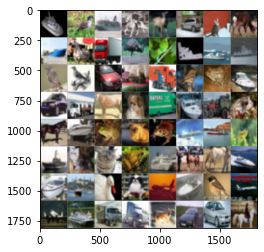

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

torchvision.transforms.functional.resize
transform = transforms.Compose(
    [
     transforms.Resize(size=(224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
])
     

batch_size = 64

idx_train = np.arange(50000)
np.random.shuffle(idx_train)
idx_train = idx_train[:1000]

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False,num_workers=2,
                                         sampler=SubsetRandomSampler(idx_train))

idx_test = np.arange(10000)
np.random.shuffle(idx_test)
idx_test = idx_test[:1000]

testset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False,num_workers=2)


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

You will be able to display the filters of the first convolutional layer, and compare these filters for the pre-trained network and the one trained on CIFAR-10, by viewing them with the following script:

In [4]:
def imshow_filters(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_weights(MyModel):
  """Displays the filters of the 1st convolutional layer
  of the input model 
  Input:
  - MyModel: the input model
  """
  ii = 0
  filter = MyModel.features[ii].weight.cpu().data
  #Normalizing the values to [0,1]
  f_min, f_max = filter.min(), filter.max()
  filter = (filter - f_min) / (f_max - f_min)
  print("The filter shape is {}".format(filter.shape))
  imshow_filters(torchvision.utils.make_grid(filter))


We have intentionally reduced the size of the images to speed up training. Note that AlexNet being is designed for images of size 224 by 224, we apply a scaling transformation (by the bilinear interpolation method, seen in TD2).

In the following, we will use the following training loop:

In [5]:
criterion = nn.CrossEntropyLoss()

def accuracy(net, test_loader, cuda=True):
  net.eval()
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          if cuda:
            images = images.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          outputs = net(images)
          
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
  net.train()
  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))
  
  return 100.0 * correct

In [6]:
def train(net, optimizer, train_loader, test_loader, loss,  n_epoch = 5,
          train_acc_period = 100,
          test_acc_period = 5,
          cuda=True):
  loss_train = []
  loss_test = []
  total = 0
  for epoch in range(n_epoch):  # loop over the dataset multiple times
      running_loss = 0.0
      running_acc = 0.0
      for i, data in enumerate(train_loader, 0):

          # get the inputs
          inputs, labels = data
          if cuda:
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          # print(inputs.shape)
          
          # zero the parameter gradients
          optimizer.zero_grad()

          outputs = net(inputs)
          
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total += labels.size(0)

          # print statistics
          running_loss = 0.33*loss.item()/labels.size(0) + 0.66*running_loss
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()/labels.size(0)
          running_acc = 0.3*correct + 0.66*running_acc
          if i % train_acc_period == train_acc_period-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
            print('[%d, %5d] acc: %.3f' %(epoch + 1, i + 1, running_acc))
            running_loss = 0.0
            total = 0
            
      if epoch % test_acc_period == test_acc_period-1:
          cur_acc, cur_loss = accuracy(net, test_loader, cuda=cuda)
          print('[%d] loss: %.3f' %(epoch + 1, cur_loss))
          print('[%d] acc: %.3f' %(epoch + 1, cur_acc))
      
  print('Finished Training')

### Question 2 
Run the following code and compare the performance between (i) the model and (ii) its pre-trained version. Specifically, compare the filters of the first convolutional layers.

In [7]:
# This is the main part where you run the training and test loops and compute accuracy
net = alexnet(num_classes=10, pretrained=False)

use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion,  n_epoch = 50,
      train_acc_period = 10,
      test_acc_period = 1000)
show_weights(net)
accuracy(net, testloader, cuda=use_cuda)

KeyboardInterrupt: 

In [ ]:
net = alexnet(num_classes=10, pretrained=True)

use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion,  n_epoch = 50,
      train_acc_period = 10,
      test_acc_period = 1000)
show_weights(net)
accuracy(net, testloader, cuda=use_cuda)

# VGG-Net

The VGG-Net architecture developed by the Visual Geometry Group team at the University of Oxford won second place in the ImageNet 2014 challenge. The variants of VGG-Net obtains up to 7.3% top-5 error on the ImageNet 2012 challenge vs 15.3% for AlexNet.

The VGG-Net architecture is available in several variants presented in the following table:

![](https://drive.google.com/uc?export=view&id=1JB2rzZHiePoKlwqqeeHg-yTwIvMjw4-m)

In VGG-Net: 
* All the convolutions use a kernel of size 3 by 3 with a padding of 1. The convolutions therefore *preserve* the size of the image.
* All the max pooling layers have a size of 2 by 2 and a stride of 2. 
* An adaptive avg pooling layer is applied before classifying it so as to reduce the image to a size 7 by 7. This is then vectorized, then sent to the classifier.

Note that the "features" part of VGG-Net can be stored in a list with a simple loop going through a list of parameters (here `cfg ['A']`). 

# Question 3

You need to complete the `make_layers` function with the following code. 
Note, if `batch_norm == True` we will need to add a batch norm layer between each convolutional layer and the following ReLu layer.

In [8]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth' # bn: batch normalization
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
  layers = []
  in_ch = 3
  for elm in cfg:
    if elm=='M':
      layers.append(nn.MaxPool2d(2, stride = 2))
    else: 
      layers.append(nn.Conv2d(in_ch, elm, kernel_size= 3, padding = 1))
      if batch_norm:
        layers.append(nn.BatchNorm2d(elm))
      layers.append (nn.ReLU())
      in_ch = elm
  return nn.Sequential(*layers)


cfg = { # M stands for max pooling 
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

### Question 4
As you did with AlexNet, evaluate (using the following functions) version A of VGG-Net (i) with and (ii) without pre-training on ImageNet. 
Use `n_epoch = 15`. 

Bonus: do the same for version E. 

In [9]:
def vgg_11_classifier(num_classes):
  classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )
  return classifier
  
def vgg11_bn(num_classes, pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs) # change cfg version for bonus
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn'])) # change model url for bn
    model.classifier = vgg_11_classifier(num_classes)
    return model

In [ ]:
net = vgg11_bn(num_classes=10, pretrained=True)

use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion,  n_epoch = 50,
      train_acc_period = 10,
      test_acc_period = 1000)
show_weights(net)
accuracy(net, testloader, cuda=use_cuda)

In [ ]:
net = vgg11_bn(num_classes=10, pretrained=False)

use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion,  n_epoch = 50,
      train_acc_period = 10,
      test_acc_period = 1000)
show_weights(net)
accuracy(net, testloader, cuda=use_cuda)

# ResNet

The ResNet architecture developed at Microsoft won the ImageNet 2015 challenge with a top-5 error of 3.57%. Rather than using a big convolutional kernel, the idea behind ResNet is replacing it with several successive layers using small kernels, introducing more non-linearity and depth into the model. This nevertheless poses a problem for gradient descent, and in particular increases the risk of saturation of the gradients due to the numerous ReLu activations. The simple (yet effective) idea behind ResNet is to use connections that bypass nonlinearities, so the gradient can easily 'go down' by taking these short circuits. One way to interpret this idea is to let the network self-regulate the amount of nonlinearities in its structure.

# Residual Block

The figure below displays the Residual Block of ResNet. 

![](https://drive.google.com/uc?export=view&id=111dS4Trq3HdRb0-9BzzimEMDy4QAlZI9)


Denote the input by 𝐱. We assume that the desired underlying mapping we want to obtain by learning is 𝑓(𝐱), to be used as the input to the activation function on the top. On the left side of the figure, the portion within the dotted-line box must directly learn the mapping  𝑓(𝐱). On the right, the portion within the dotted-line box needs to learn the residual mapping  𝑓(𝐱)−𝐱 , which is how the residual block derives its name. If the identity mapping  𝑓(𝐱)=𝐱  is the desired underlying mapping, the residual mapping is easier to learn: we only need to push the weights and biases of the upper weight layer (e.g., fully-connected layer and convolutional layer) within the dotted-line box to zero. The right diagram illustrates the residual block of ResNet, where the solid line carrying the layer input 𝐱 to the addition operator is called a Residual Connection (or shortcut connection). With residual blocks, inputs can forward propagate faster through the residual connections across layers.

ResNet follows VGG’s full 3×3 convolutional layer design. 
* The residual block has two 3×3  convolutional layers with the same number of output channels. * Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. 
* Then, we skip these two convolution operations and add the input directly before the final ReLU activation function. 

This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional  1×1 convolutional layer to transform the input into the desired shape for the addition operation. 

# Question 5
Fill in the code below so that it generates two types of networks: (1) one where we add the input to the output before applying the ReLU nonlinearity whenever use_1x1conv=False, and (2) one where we adjust channels and resolution by means of a 1×1 convolution before adding. 
This is displayed in the following figure:

![](https://drive.google.com/uc?export=view&id=1iE0l_2hEiNLbk8bTOSjQTbqQJaN9jVGR)


In [10]:
import torch
from torch import nn
from torch.nn import functional as F

class BasicBlock(nn.Module): 
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
        if use_1x1conv:
          self.res = nn.Conv2d(input_channels, num_channels, stride=strides, kernel_size = 1)
        else:
          self.res = nn.Identity ()

        

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        #print(self.res(X).size())
        Y = Y + self.res(X)
        return F.relu(Y)

# Question 6

For a random input: 
`X = torch.rand(4, 3, 6, 6)`, create two `Residual` blocks with (1) input and output of the same shape, (2) halve the output height and width while increasing the number of output channels. 
Use `input_channels=3` and `num_channels=3`. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


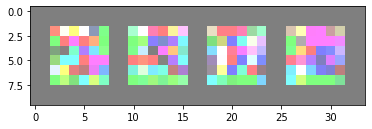

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


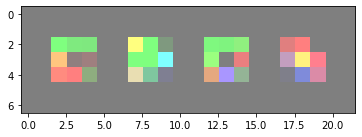

In [11]:
X = torch.rand(4, 3, 6, 6)
resBlock1 = BasicBlock(3, 3)(X)
resBlock2 = BasicBlock(3,3,use_1x1conv=True ,strides = 2)(X)
imshow(torchvision.utils.make_grid(resBlock1))
imshow(torchvision.utils.make_grid(resBlock2))

# ResNet architecture 

The first layers of ResNet are 
* a 7×7  convolutional layer with 64 output channels and a stride of 2, which is followed by 
* a 3×3  max pooling layer with a stride of 2, 
* and a batch normalization layer.

Note that in ResNet the batch normalization is added after each convolutional layer.

# Question 7

Fill in the code below:


In [15]:
b1 = nn.Sequential( nn.Conv2d(1, 64, kernel_size = 7, stride = 2),
                   nn.MaxPool2d(3, stride= 2),
                   nn.BatchNorm2d(64))

## Modules

ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels. The number of channels in the first module is the same as the number of input channels. Since a maximum pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

# Question 8 

You need to implement this `_make_layer` module (code below). Note that you need to perfrom a special processing on the first module.

In [16]:
def _make_layer(input_channels, num_channels, num_residuals,
                 first_block=False):
  res_block = []
  
  for i in range(num_residuals):
    # TODO 
    if first_block:
      res_block.append(BasicBlock(num_channels, num_channels))
    else:
      res_block.append(BasicBlock(input_channels, num_channels, strides=2,use_1x1conv=True))
      first_block = True
  return res_block

## Adding all modules to ResNet

Now, we need to add all modules to ResNet. For this, you need the following code:

In [17]:
b2 = nn.Sequential(*_make_layer(64, 64, 2, first_block=True))
b3 = nn.Sequential(*_make_layer(64, 128, 2))
b4 = nn.Sequential(*_make_layer(128, 256, 2))
b5 = nn.Sequential(*_make_layer(256, 512, 2))

Finally, we add a global average pooling layer, followed by the fully-connected layer output:

In [18]:
num_classes = 10 
toy_net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

## ResNet-18

In total, there are 4 convolutional layers in each module (excluding the 1×1 convolutional layer). Together with the first 7×7 convolutional layer and the final fully-connected layer, there are 18 layers in total. Therefore, this model is commonly known as ResNet-18. 
The figure below displays this:

![](https://drive.google.com/uc?export=view&id=1omcoC6FNmzWbRIi6W06dm6G9aPq3e_Ag)

# ResNet-50, ResNet-101, ResNet152
The structure of ResNet is simple and quite easy to modify. Simply, by configuring different numbers of channels and residual blocks in the module, we can create different ResNet models, such as the deeper 152-layer ResNet-152. This is the reason that ResNet have been widely used by the community. 

## Shape changes

Before training, we observe how the input shape changes across different modules in ResNet. The resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features.

In [19]:
X = torch.rand(size=(4, 1, 224, 224))
print(X.size())
for layer in toy_net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)
        

torch.Size([4, 1, 224, 224])
Sequential output shape:	 torch.Size([4, 64, 54, 54])
Sequential output shape:	 torch.Size([4, 64, 54, 54])
Sequential output shape:	 torch.Size([4, 128, 27, 27])
Sequential output shape:	 torch.Size([4, 256, 14, 14])
Sequential output shape:	 torch.Size([4, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([4, 512, 1, 1])
Flatten output shape:	 torch.Size([4, 512])
Linear output shape:	 torch.Size([4, 10])


## Training ResNet18

First download CIFAR 10 

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

torchvision.transforms.functional.resize
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
])
     
img_size = 28
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False,num_workers=2)

#Question 9
You need to create a ResNet class using the `BasicBlock` class from Question 5 and the methodology that we followed above. 

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class ResNet(nn.Module): 
    def __init__(self, block, num_blocks, num_classes=1000, num_filters=64, input_dim=3):
        super(ResNet, self).__init__()
        self.inplanes = num_filters
        verbose = False

        # first conv layer (b1)
        self.conv1 = nn.Conv2d(input_dim, num_filters, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # all subsequent ones 
        
        # b2 = nn.Sequential(*_make_layer(64, 64, 2, first_block=True))
        #self.layer1 = self._make_layer(block, num_filters, num_blocks[0], stride=1, first_block=True)
        self.layer1 = self._make_layer(num_filters, num_filters, num_blocks[0], first_block=True)
        
        # b3 = ...
        self.layer2 = self._make_layer(num_filters, 2*num_filters, num_blocks[1])# TODO 
        num_filters *= 2
        
        
        # b4 = ...
        self.layer3 = self._make_layer(num_filters, 2*num_filters, num_blocks[2])# TODO 
        num_filters *= 2
        
        
        # b5 = ...
        self.layer4 = self._make_layer(num_filters, 2*num_filters, num_blocks[3])# TODO 
        num_filters *= 2
        
        self.avgPool = nn.AdaptiveAvgPool2d((1,1))

        self.layers = nn.Sequential(*self.layer1, *self.layer2, *self.layer3, *self.layer4, self.avgPool, nn.Flatten(), nn.Linear(512, 10))
        # TODO 
        # ... 
        

    """def _make_layer(input_channels, num_channels, num_residuals,
                 first_block=False):
        res_block = []
        for ii in range(num_residuals):
            # TODO 
            # ...
            # remember: self.inplanes *=2 if ii = 0 and not first block 

        
        return # TODO ..."""

    def _make_layer(self, input_channels, num_channels, num_residuals,
                    first_block=False):
      res_block = []
      
      for i in range(num_residuals):
        # TODO 
        if first_block:
          res_block.append(BasicBlock(num_channels, num_channels))
        else:
          res_block.append(BasicBlock(input_channels, num_channels, strides=2,use_1x1conv=True))
          first_block = True
      return res_block

    def forward(self, x): 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #blocks = nn.Sequential(*self.layer1, *self.layer2, *self.layer3, *self.layer4, self.avgPool)
        x = self.layers(x)
        # TODO 
        # ...
        return x



# Question 10-a

Train the above architecture using the code below:

In [ ]:
MyNet = ResNet(BasicBlock, [2,2,2,2])

use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    MyNet.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(MyNet.parameters(),lr=learning_rate)
train(MyNet, optimizer, trainloader, testloader, criterion,  n_epoch = 5,
      train_acc_period = 10, test_acc_period = 1000)

accuracy(MyNet, testloader, cuda=use_cuda)

# Question 10-b
Compare the results with the pre-trained model from the original ResNet:

In [ ]:
import torchvision
from torchvision import *

GT_resnet18 = models.resnet18(pretrained=True)

use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    GT_resnet18.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(GT_resnet18.parameters(),lr=learning_rate)

train(GT_resnet18, optimizer, trainloader, testloader, criterion,  n_epoch = 5,
      train_acc_period = 100, test_acc_period = 1000)
accuracy(GT_resnet18, test_loader=testloader, cuda=use_cuda)

# InceptionNet (Bonus)

The [InceptionNet](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/43022.pdf) architecture developed at Google won the ImageNet 2014 challenge with a top-5 error of 6.7%. A problem that appears in the design of a CNN architecture is the choice of the size of the convolutional kernels. More generally, in image processing, the question of which scale to detect patterns always arises. The InceptionNet architecture addresses this problem by relying on the notion of block inception. This is a multi-scale block allowing the network to choose between different scales / resolutions / pooling.

You need complete the Inception class implementing the block:

![](https://drive.google.com/uc?export=view&id=1RrZuOTGXU9VE9L9eRjiMCqwAW3gl57zB)

described in the GoogLeNet article (Figure 2b).

The following code implements a truncated version of GoogLeNet:

In [ ]:
import torch
import torch.nn as nn


class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
		# TODO

    def forward(self, x):
		# TODO


class GoogLeNet(nn.Module):
    def __init__(self, input_dim=3):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(input_dim, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        
        self.layer1 = Inception(192,  64,  96, 128, 16, 32, 32)
        
        self.layer2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.layer3 = Inception(480, 192,  96, 208, 16,  48,  64)
        
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.linear = nn.Linear(512, 10)
        

    def forward(self, x):
        x = self.pre_layers(x)

        x = self.layer1(x)
        x = self.max_pool(x)
        x = self.layer2(x)
        x = self.max_pool(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


# Question 11 (Bonus) 

Test your GoogLeNet implementation on the FashionMNIST dataset:

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

transform = transforms.Compose(
    [transforms.Resize(size=(32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
     
batch_size = 64

trainset = torchvision.datasets.FashionMNIST("./data",download=True,train=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)

testset = torchvision.datasets.FashionMNIST("./data",download=True,train=False,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Colab Cheatsheet 

*   show keyboard shortcuts, Ctrl/Cmd M H, H 
*   Insert code cell above, Ctrl/Cmd M A, A
*   Insert code cell below, Ctrl/Cmd M B, B
*   Delete cell/selection, Ctrl/Cmd M D, DD
*   Interrupt execution, Ctrl/Cmd M I, II
*   Convert to code cell, Ctrl/Cmd M Y, Y
*   Convert to text cell, Ctrl/Cmd M M, M
*   Split at cursor, Ctrl/Cmd M -, Ctrl Shift -
